

- Vision Trasformer(ViT)

 - Self-Attention 실습

 - ViT 실습

 - 김치Dataset에 ViT 실습



# 안내사항 : 훈련 중 Colab 안 끊기도록 설정하기

-------------------------------------
Google Colab 환경은 약 90분 이상 비활성화 되어있으면 실행이 끊기도록 설정되어 있습니다. 다음과 같은 방법을 통해 비활성화되는 것을 막을 수 있습니다!

1. Chrome에서 'F12' 키 눌러서 개발자 도구 들어가기

2. 상단 메뉴에서 Console들어가기

3. 하단에 있는 '>' 표시 오른쪽 입력창에 다음 코드 입력하기
function ClickConnect(){
	console.log("Working");
	document.querySelector("colab-toolbar-button").click()
} setInterval(ClickConnect, 600000)
-------------------------------------

# 1장: ViT 이해 및 기본적인 응용


## Self-Attention


Self-Attention in ViT Model

Self-Attention 이 실제 모델에서는 어떻게 동작할까?
    
Self-Attention이 ViT 내부에서 어떻게 동작하는지 알아봅시다.

[ViT Pytorch Repo](https://github.com/lucidrains/vit-pytorch/blob/1bae5d3cc58448f05d1252be306bbf48d9c5fede/vit_pytorch/vit.py#L35)

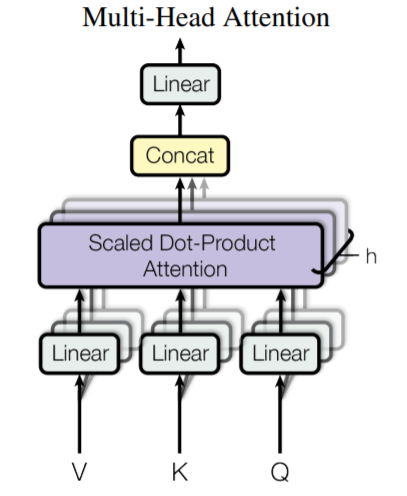

다음과 같이 nn.Module 을 상속받은 Attention class 를 만듭니다.

<img src="https://drive.google.com/uc?export=download&id=1K-bJTOvv9PSJ1lDD0BfzBWmarHZ-MTVn"  onerror="this.style.display='none'" width="400" height="200" /><br><br>



In [ ]:
!pip install einops
import torch
import torch.nn as nn
from einops import rearrange
import cv2
from einops import rearrange, repeat, reduce
from einops.layers.torch import Rearrange

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head * heads                                # dim_head = head의 차원. => inner_dim = (head의 차원) * (head 수) = 전체 차원.
        self.scores = None
        self.heads = heads                                          # head 수
        self.scale = dim_head ** -0.5                               # Scaled Dot Product 에서 나눌 차원수.

        self.attend = nn.Softmax(dim = -1)                          # Softmax 레이어
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)   # Query, Key, Value 를 얻어낼 학습가능한 파라미터

        self.to_out = nn.Sequential(                                # 아웃풋 출력. 헤드마다의 셀프어텐션값을 합쳐줌.
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)                     # x 값을 Linear 레이어에 통과시켜 Query, Key, Value 를 얻어낸다.

        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv) # qkv 를 각각 head 수로 나누어 쪼개주는 연산.

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale    # scaled dot product

        attn = self.attend(dots)                                    # Softmax 통과

        out = torch.matmul(attn, v)                                 # Value와 연산

        out = rearrange(out, 'b h n d -> b n (h d)')                # head 로 나뉜 값을 다시 뭉쳐주는 과정

        out = self.to_out(out)
        self.scores = attn

        return out                                                  # 헤드마다의 셀프어텐션값을 합쳐줌.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 5.2 MB/s eta 0:00:00


실제 attention module layer를 뽑아봅니다.


In [ ]:
attn = Attention(512) # dim = 들어갈 데이터의 차원
attn

Attention(
  (attend): Softmax(dim=-1)
  (to_qkv): Linear(in_features=512, out_features=1536, bias=False)
  (to_out): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): Dropout(p=0.0, inplace=False)
  )
)

In [ ]:
x = torch.rand(1,3,512)
y = attn(x)
print(y.size())

torch.Size([1, 3, 512])


## ViT

### 다음 순서로 ViT 를 차근차근 알아봅시다.



---



1. 입력 데이터 준비 [Prepare Inputs]

1. Patch Embedding

1. Positional Embedding w/ cls_token

1. Tranformer Blocks

1. MLP Head

1. Completed Model

1. Training

1. Inference

1. Attention Map Visualization

### 1. 입력 데이터 준비 [Prepare Inputs] - CIFAR10

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms
import os

print(torch.cuda.is_available()) # cuda 가능 여부 확인
device = 'cuda' if torch.cuda.is_available() else 'cpu' # cuda device 설정!!

# 시드 고정
torch.manual_seed(1)
if device == 'cuda':
    torch.cuda.manual_seed_all(1)

True


Data augmentation, 성능 향상을 위해 transform에 모듈 추가 하셔도 됩니다!

In [ ]:
transform_train = transforms.Compose([
    # transforms.RandomHorizontalFlip(0.5),
    # transforms.RandomVerticalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([transforms.ToTensor(),
                                  transforms.Resize((32, 32)),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                 ])

Train dataset visualization 하는 부분입니다.

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


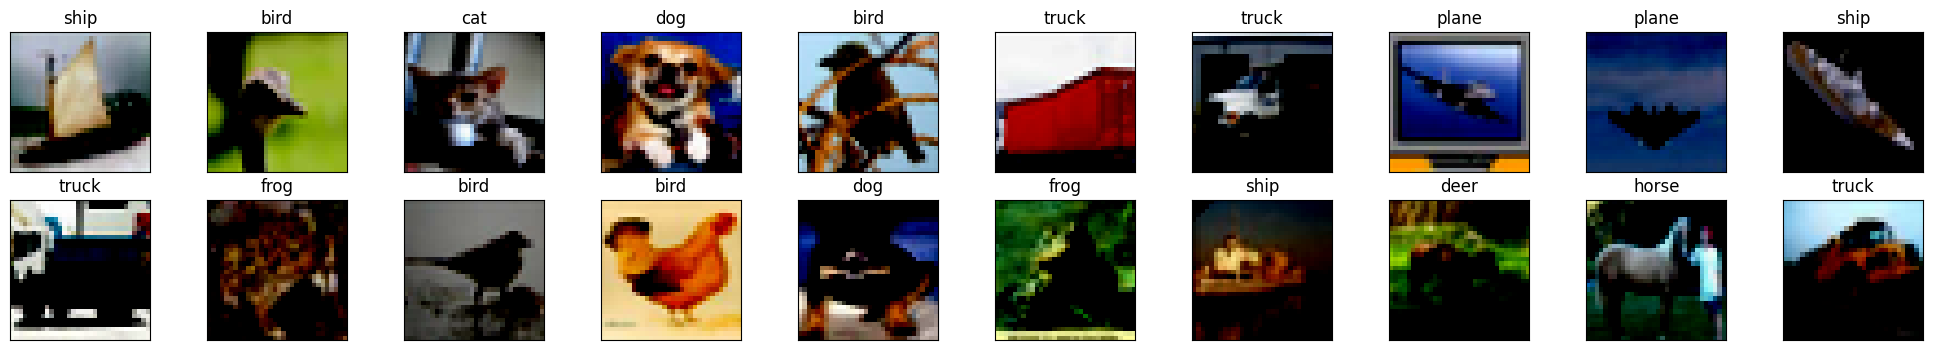

In [ ]:

batch_size = 128 # 배치 사이즈

# dataset & dataloader 세팅
trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)


def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array([0.5, 0.5, 0.5] + np.array([0.5, 0.5, 0.5]))
  image = image.clip(0, 1)
  return image

classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

fig = plt.figure(figsize=(25, 4))


# train dataloader에 잘 담긴 (image, label) 쌍 확인
for i_batch, sample_batched in enumerate(train_loader):

  images, labels = sample_batched[0],sample_batched[1]
  for i in np.arange(20):
    # row 2 column 10
    ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[i]))
    ax.set_title(classes[labels[i].item()])

  break


### 2. Patch Embedding

patch embedding이 어떻게 진행되는지 알아봅시다.

In [ ]:
from einops.layers.torch import Rearrange

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size):
        super().__init__()

        image_height, image_width = image_size
        patch_height, patch_width = patch_size

        self.to_patch_embedding = Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width)

    def forward(self, img):
        x = self.to_patch_embedding(img)
        return x

vit = ViT(image_size=(32,32),patch_size=(8,8))

ViT class는 들어온 이미지를 주어진 patch_size로 embedding 해줍니다.

위에서 ViT class를 선언하고 아래에서 image_size = 32, patch_size = 8 인 ViT instance를 호출합니다.

In [ ]:
print(images[0:1].shape) # (batch_size, channel, height, width)
print(1*3*32*32)

torch.Size([1, 3, 32, 32])
3072


아래에서 실제 이미지를 vit instance에 넣어 봅니다.

이때, output은 patch가 되고 size는 아래와 같습니다.

In [ ]:
patches = vit(images[0:1])
print(patches.shape) # (batch_size, patch_num, patch_dim)
print(1*16*192)

torch.Size([1, 16, 192])
3072


기존 이미지와 patch embedding한 tensor의 크기가 같은것을 알 수 있습니다.

아래는 이를 시각화하는 코드입니다.

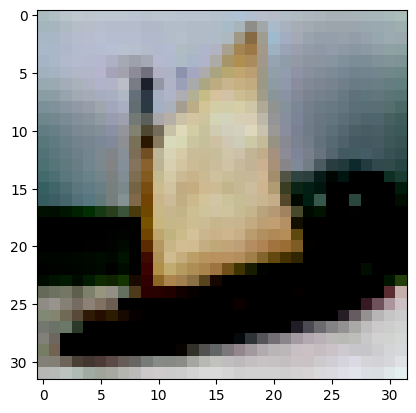

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(images[0].permute(1,2,0)) # pyplot으로 이미지 뽑기 위해 차원 순서 변경

In [ ]:
patches_img = patches.reshape(16,8,8,3)
patches_img.shape

torch.Size([16, 8, 8, 3])

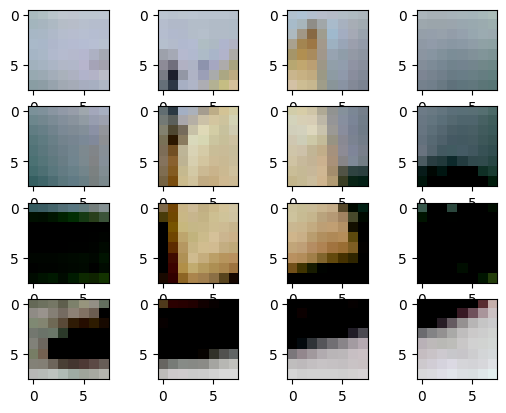

In [ ]:
# 한 image가 16개의 patch로 나눠진 것 확인
import numpy as np
pat_size = int(np.sqrt(patches_img.shape[0]))
for i in range(0,pat_size):
    for j in range(0,pat_size):
        plt.subplot(pat_size, pat_size, i*4 + j+1)
        plt.imshow(patches_img[i*4 +j])
plt.show()

실제로 patch들은 위와 같이 쪼개져서 transformer로 들어가게 됩니다.

### 3. Positional Embedding w/ cls_token

다음은 embedding된 patch들에 cls token과 positional embedding을 추가하는 작업입니다.

<img src="https://drive.google.com/uc?export=download&id=1vxG6BgT2RpMNXBDG6ajWpMnjqJo29_ps"  onerror="this.style.display='none'" width="500" height="500" /><br><br>

In [ ]:
from einops import repeat

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, dim, channels = 3, dropout = 0.):
        super().__init__()
        image_height, image_width = image_size
        patch_height, patch_width = patch_size

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim), # 차원 : patch_dim -> dim
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim)) # Positional Embedding : 학습가능한 파라미터
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim)) # Class Token : 학습가능한 파라미터

    def forward(self, img):
        x = self.to_patch_embedding(img) # Patch Embedding 수행.
        b, n, _ = x.shape # batch_size와 Patch_num 을 추출함.

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b) # batch_size 만큼 Class Token 반복.
        x = torch.cat((cls_tokens, x), dim=1) # Class Token 을 X 앞에 붙여줌.

        x += self.pos_embedding # Positional Embedding 값을 더해줌.

        return x

class_token을 패치의 dimension과 같은 학습가능한 파라미터로 생성해줍니다.

또한, positional_embedding을 수행할 수 있는 학습가능한 파라미터를 patch개수 + 1개 만큼 생성해 줍니다.

(cls_token을 하나 더하기 때문)

생성된 cls_token을 embedding된 patch들과 합쳐주고(concat) 그 이후 positional embedding parameter를 더해줍니다.(sum)

In [ ]:
vit = ViT(image_size=(32,32),patch_size=(8,8), dim=16)
x = vit(images[0:1])
x.shape # (batch_size, patch_num + 1, dim)

torch.Size([1, 17, 16])

### 4. Transformer Blocks

<img src="https://drive.google.com/uc?export=download&id=1IFzSRnUJTdLIyWk-z47Jv08ng_5lF-fc"  onerror="this.style.display='none'" width="200" height="400" /><br><br>



위 그림과 같은 transformer block을 만들어 봅시다.

먼저 PreNorm이라는 layer normalization을 진행하는 class를 정의합니다.

Multi-head attention은 위에서 attention class로 선언하였으니 또다시 만들 필요가 없습니다.

다음으로 MLP class를 선언합니다. MLP class를 종종 FeedForward network라고 부르기도 합니다.

마지막으로 PreNorm, FeedForward, MSA가 합쳐진 transformer class를 정의합니다

In [ ]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        self.atten_scores = None
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head,dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout))
            ]))

    def forward(self, x):
        atten_scores = []
        for attn, ff in self.layers:
            y = attn(x)
            attn_score = attn.fn.scores
            x = y + x
            x = ff(x) + x
            atten_scores.append(attn_score)
        return x,atten_scores

이제 patch embedding과 transformer 가 존재하는 ViT class를 정의해 줍니다.

In [ ]:
class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels = 3, dim_head = 64, dropout = 0.):
        super().__init__()
        image_height, image_width = image_size
        patch_height, patch_width = patch_size

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding

        x,atten_scores = self.transformer(x)

        return x

### 5. MLP Head


<img src="https://drive.google.com/uc?export=download&id=1xHm5lZEwROKuZ0UioUA56B5y0V5LcKZk"  onerror="this.style.display='none'"  width="1000" height="500"  /><br><br>


이제 transformer 블락 이후에 MLP head layer를 추가해줍니다.

MLP Head에서는 classification을 위해서 class개수만큼의 confidence가 output으로 나옵니다.


In [ ]:
class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels = 3, dim_head = 64, dropout = 0.):
        super().__init__()
        image_height, image_width = image_size
        patch_height, patch_width = patch_size

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding

        x,atten_scores = self.transformer(x)

        x = x[:, 0]

        return self.mlp_head(x),atten_scores

In [ ]:
vit = ViT(image_size=(32,32),patch_size=(8,8), num_classes=10, dim=16, depth=6, heads=8, mlp_dim=64)

In [ ]:
x,atten_scores = vit(images[0:1])
x.shape # (batch_size, classes)

torch.Size([1, 10])

### 6. Completed Model

마지막으로 mlp_head에 transformer output을 넣기 전 pooling을 진행해 줍니다.

이때 cls_token을 mlp_head에 넣을지 아니면 나머지 토큰들의 mean 값을 넣을지 선택할 수 있습니다.

In [ ]:
class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = image_size
        patch_height, patch_width = patch_size

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'
        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x, atten_scores = self.transformer(x)  # b,gh*gw+1,d
        att_mat = torch.stack(atten_scores).squeeze(1)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        return self.mlp_head(x), att_mat

In [ ]:
##################### parameters
patch_size = 4
dim = 512
depth = 6
num_heads = 16
mlp_dim = 512
training_epochs = 50
learning_rate = 0.1
dropout = 0.1
emb_dropout = 0.1

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

model = ViT(
    image_size = (32,32),
    patch_size = (patch_size,patch_size),
    num_classes = 10,
    dim = dim,
    depth = depth,
    heads = num_heads,
    mlp_dim = mlp_dim,
    dropout = dropout,
    emb_dropout = emb_dropout
)

model = model.to(device)

print(model)

Files already downloaded and verified
ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
    (1): Linear(in_features=48, out_features=512, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (attend): Softmax(dim=-1)
            (to_qkv): Linear(in_features=512, out_features=3072, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=1024, out_features=512, bias=True)
              (1): Dropout(p=0.1, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=512, out_features=512, bias=True)
       

### 7. Training

Optimizer와 scheduler등을 조절하여 성능을 올리셔도 좋습니다!

In [ ]:
# CIFAR10 은 다중분류 -> CrossEntropyLoss
criterion = torch.nn.CrossEntropyLoss().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=0.1)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

다음 셀 실행은 약 두시간 가량 소요됩니다.

실행시키고 잠시 쉬세요 ㅎㅎ

100%|██████████| 391/391 [01:44<00:00,  3.74it/s]


[Epoch: 1] training loss = 3.09, training accuracy: 18.6%


100%|██████████| 391/391 [01:46<00:00,  3.66it/s]


[Epoch: 2] training loss = 2.01, training accuracy: 25.1%


100%|██████████| 391/391 [01:49<00:00,  3.57it/s]


[Epoch: 3] training loss = 1.92, training accuracy: 29.6%


100%|██████████| 391/391 [01:49<00:00,  3.57it/s]


[Epoch: 4] training loss = 1.85, training accuracy: 32.9%


100%|██████████| 391/391 [01:49<00:00,  3.56it/s]


[Epoch: 5] training loss = 1.78, training accuracy: 36.0%


100%|██████████| 391/391 [01:49<00:00,  3.56it/s]


[Epoch: 6] training loss = 1.69, training accuracy: 38.8%


100%|██████████| 391/391 [01:49<00:00,  3.57it/s]


[Epoch: 7] training loss = 1.62, training accuracy: 41.5%


100%|██████████| 391/391 [01:49<00:00,  3.56it/s]


[Epoch: 8] training loss = 1.56, training accuracy: 43.7%


100%|██████████| 391/391 [01:49<00:00,  3.56it/s]


[Epoch: 9] training loss = 1.51, training accuracy: 45.7%


100%|██████████| 391/391 [01:49<00:00,  3.57it/s]


[Epoch: 10] training loss = 1.46, training accuracy: 47.5%
model saved @10


100%|██████████| 391/391 [01:50<00:00,  3.55it/s]


[Epoch: 11] training loss = 1.41, training accuracy: 49.2%


100%|██████████| 391/391 [01:49<00:00,  3.57it/s]


[Epoch: 12] training loss = 1.37, training accuracy: 50.7%


100%|██████████| 391/391 [01:49<00:00,  3.57it/s]


[Epoch: 13] training loss = 1.33, training accuracy: 52.1%


100%|██████████| 391/391 [01:50<00:00,  3.55it/s]


[Epoch: 14] training loss = 1.3, training accuracy: 53.6%


100%|██████████| 391/391 [01:49<00:00,  3.57it/s]


[Epoch: 15] training loss = 1.27, training accuracy: 54.2%


100%|██████████| 391/391 [01:49<00:00,  3.57it/s]


[Epoch: 16] training loss = 1.24, training accuracy: 55.2%


100%|██████████| 391/391 [01:49<00:00,  3.56it/s]


[Epoch: 17] training loss = 1.21, training accuracy: 56.4%


100%|██████████| 391/391 [01:49<00:00,  3.56it/s]


[Epoch: 18] training loss = 1.19, training accuracy: 57.4%


100%|██████████| 391/391 [01:50<00:00,  3.55it/s]


[Epoch: 19] training loss = 1.17, training accuracy: 58.3%


100%|██████████| 391/391 [01:49<00:00,  3.56it/s]


[Epoch: 20] training loss = 1.15, training accuracy: 59.0%
model saved @20


100%|██████████| 391/391 [01:49<00:00,  3.57it/s]


[Epoch: 21] training loss = 1.12, training accuracy: 59.8%


100%|██████████| 391/391 [01:49<00:00,  3.56it/s]


[Epoch: 22] training loss = 1.1, training accuracy: 60.6%


100%|██████████| 391/391 [01:49<00:00,  3.57it/s]


[Epoch: 23] training loss = 1.08, training accuracy: 61.1%


100%|██████████| 391/391 [01:49<00:00,  3.56it/s]


[Epoch: 24] training loss = 1.06, training accuracy: 61.9%


100%|██████████| 391/391 [01:49<00:00,  3.57it/s]


[Epoch: 25] training loss = 1.04, training accuracy: 62.8%


100%|██████████| 391/391 [01:49<00:00,  3.57it/s]


[Epoch: 26] training loss = 1.02, training accuracy: 63.4%


100%|██████████| 391/391 [01:49<00:00,  3.56it/s]


[Epoch: 27] training loss = 1.01, training accuracy: 63.9%


100%|██████████| 391/391 [01:49<00:00,  3.56it/s]


[Epoch: 28] training loss = 0.99, training accuracy: 64.7%


100%|██████████| 391/391 [01:49<00:00,  3.56it/s]


[Epoch: 29] training loss = 0.969, training accuracy: 65.4%


100%|██████████| 391/391 [01:50<00:00,  3.55it/s]


[Epoch: 30] training loss = 0.952, training accuracy: 66.1%
model saved @30


100%|██████████| 391/391 [01:49<00:00,  3.57it/s]


[Epoch: 31] training loss = 0.939, training accuracy: 66.4%


100%|██████████| 391/391 [01:49<00:00,  3.56it/s]


[Epoch: 32] training loss = 0.915, training accuracy: 67.4%


100%|██████████| 391/391 [01:50<00:00,  3.55it/s]


[Epoch: 33] training loss = 0.9, training accuracy: 67.7%


100%|██████████| 391/391 [01:49<00:00,  3.57it/s]


[Epoch: 34] training loss = 0.886, training accuracy: 68.3%


100%|██████████| 391/391 [01:49<00:00,  3.56it/s]


[Epoch: 35] training loss = 0.866, training accuracy: 68.8%


100%|██████████| 391/391 [01:49<00:00,  3.56it/s]


[Epoch: 36] training loss = 0.85, training accuracy: 69.6%


100%|██████████| 391/391 [01:49<00:00,  3.57it/s]


[Epoch: 37] training loss = 0.832, training accuracy: 70.2%


100%|██████████| 391/391 [01:50<00:00,  3.55it/s]


[Epoch: 38] training loss = 0.812, training accuracy: 71.0%


100%|██████████| 391/391 [01:49<00:00,  3.57it/s]


[Epoch: 39] training loss = 0.798, training accuracy: 71.5%


100%|██████████| 391/391 [01:49<00:00,  3.56it/s]


[Epoch: 40] training loss = 0.779, training accuracy: 72.1%
model saved @40


100%|██████████| 391/391 [01:50<00:00,  3.55it/s]


[Epoch: 41] training loss = 0.763, training accuracy: 72.8%


100%|██████████| 391/391 [01:49<00:00,  3.57it/s]


[Epoch: 42] training loss = 0.749, training accuracy: 73.4%


100%|██████████| 391/391 [01:50<00:00,  3.55it/s]


[Epoch: 43] training loss = 0.732, training accuracy: 73.7%


100%|██████████| 391/391 [01:49<00:00,  3.55it/s]


[Epoch: 44] training loss = 0.711, training accuracy: 74.6%


100%|██████████| 391/391 [01:49<00:00,  3.57it/s]


[Epoch: 45] training loss = 0.693, training accuracy: 75.1%


100%|██████████| 391/391 [01:50<00:00,  3.55it/s]


[Epoch: 46] training loss = 0.677, training accuracy: 75.6%


100%|██████████| 391/391 [01:49<00:00,  3.56it/s]


[Epoch: 47] training loss = 0.659, training accuracy: 76.3%


100%|██████████| 391/391 [01:49<00:00,  3.57it/s]


[Epoch: 48] training loss = 0.641, training accuracy: 76.9%


100%|██████████| 391/391 [01:50<00:00,  3.55it/s]


[Epoch: 49] training loss = 0.624, training accuracy: 77.7%


100%|██████████| 391/391 [01:50<00:00,  3.55it/s]


[Epoch: 50] training loss = 0.606, training accuracy: 78.1%
model saved @50
model saved @Final


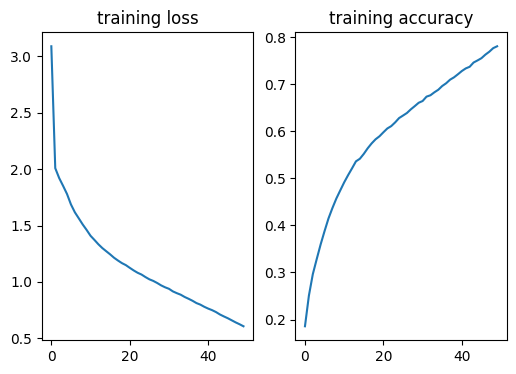

In [ ]:
# train
from tqdm import tqdm
import os
os.makedirs('/checkpoint/cifar10',exist_ok=True)
total_batch = len(train_loader)

loss_list = []
acc_list = []

for epoch in range(1,training_epochs+1):
    total_loss = 0
    correct_prediction = 0

    for idx, (X, Y) in enumerate(tqdm(train_loader)):
        X = X.to(device)
        Y = Y.to(device)

        outputs,atten_scores = model(X)
        loss = criterion(outputs, Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        correct_prediction += (torch.argmax(outputs, 1) == Y).sum()
        total_loss += loss / total_batch

    # scheduler.step()

    correct_prediction = correct_prediction/len(trainset)
    total_loss = total_loss.detach().cpu()
    correct_prediction = correct_prediction.detach().cpu()
    loss_list.append(total_loss)
    acc_list.append(correct_prediction)

    print(f'[Epoch: {epoch}] training loss = {total_loss:.3}, training accuracy: {correct_prediction*100:.3}%')
    if epoch%10 == 0:
        torch.save(model.state_dict(),f'/checkpoint/cifar10/model_{epoch}.pt')
        print(f"model saved @{epoch}")

torch.save(model.state_dict(),f'/checkpoint/cifar10/model_final.pt')
print(f"model saved @Final")

# Training Loss, Training Accuracy 에폭 단위 시각화
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(loss_list)
ax1.set_title('training loss')
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(acc_list)
ax2.set_title('training accuracy')
plt.show()

### 8. Inference

Accuracy of the network on the 10000 test images: 65 %


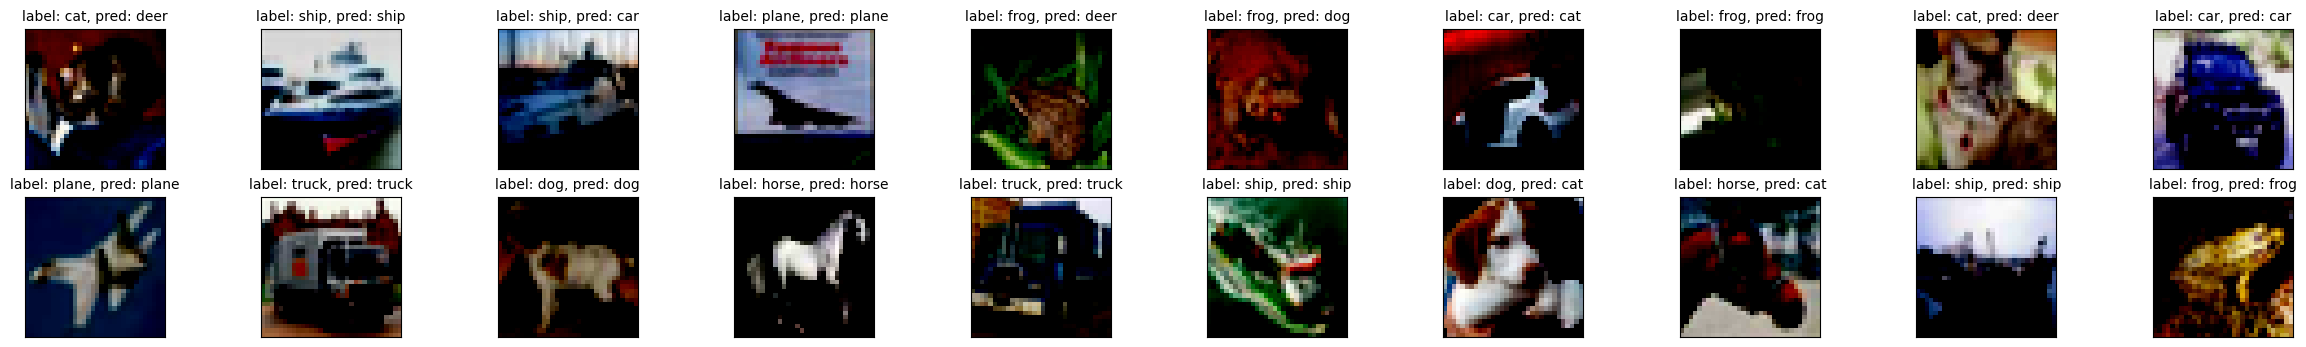

In [ ]:
model = ViT(
    image_size = (32,32),
    patch_size = (patch_size,patch_size),
    num_classes = 10,
    dim = dim,
    depth = depth,
    heads = num_heads,
    mlp_dim = mlp_dim,
    dropout = dropout,
    emb_dropout = emb_dropout
)

model.load_state_dict(torch.load('/checkpoint/cifar10/model_final.pt'))
model = model.to(device)

model.eval()
correct = 0
total = 0
fig = plt.figure(figsize=(30,4))
i = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():

    for idx, (X, Y) in enumerate(test_loader):
      images = X
      labels = Y
      X = X.to(device)
      Y = Y.to(device)
      outputs,atten_scores = model(X)
      _, predicted = torch.max(outputs.data, 1)
      total += Y.size(0)
      correct += (predicted == Y).sum().item()
      while i <20:
        # row 2 column 10
        ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
        plt.imshow(im_convert(images[i]))
        ax.set_title('label: '+classes[labels[i].item()] + f', pred: {classes[predicted[i]]}',fontsize=10)
        i+=1

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')


### 9. Attention Map Visualization

ViT모델에서 추출한 attention score를 mask로 변환하여 visualization 하는 부분입니다.

Attention map을 보면 실제 이미지에 어느 부분이 하이라이트 되는지 알 수 있습니다.

<img src="https://drive.google.com/uc?export=download&id=1w1-iB9PUXCr2y_GNzVKXRx4JZzZsB8z_
"  onerror="this.style.display='none'" width="300" height="500" /><br><br>

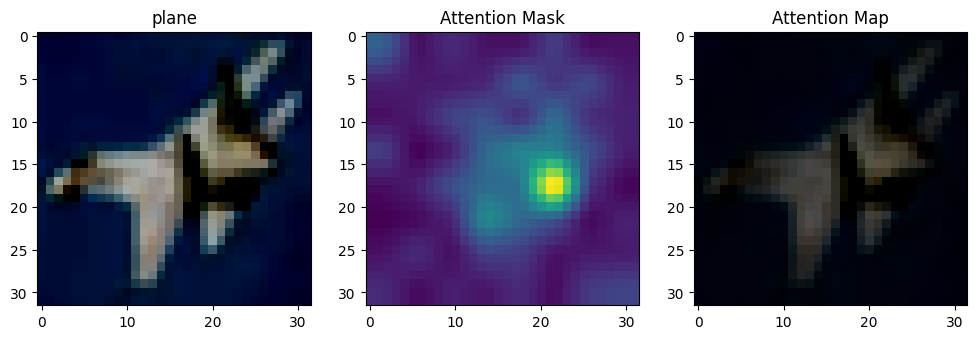

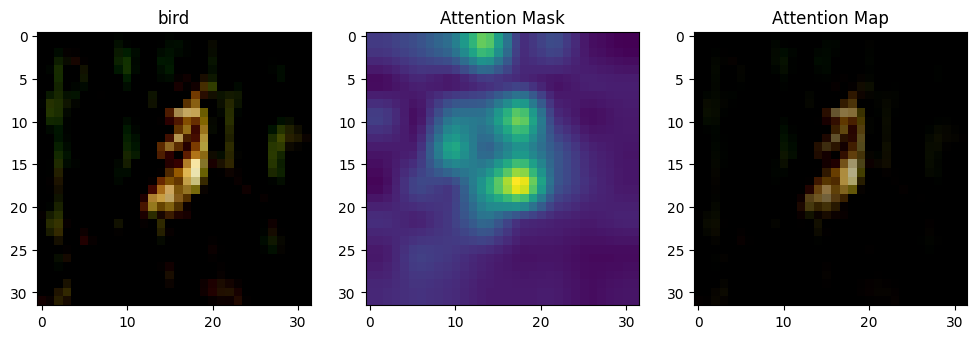

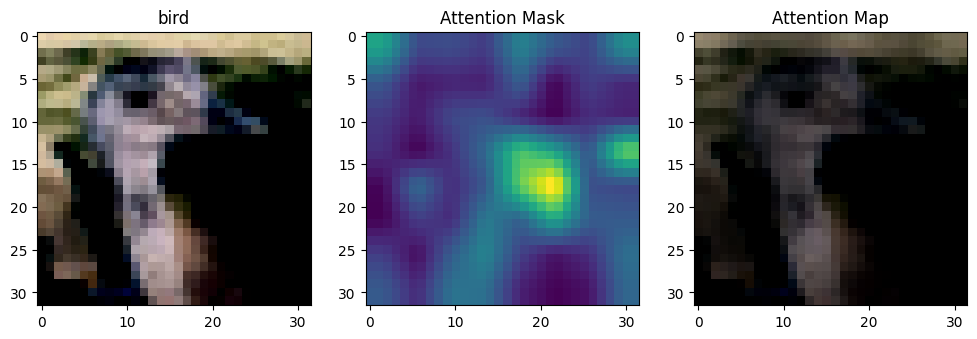

In [ ]:
import cv2
img_num = 10

k = 0
with torch.no_grad():
    for idx, (X, Y) in enumerate(test_loader):
        k+=1
        X = X.to(device)
        Y = Y.to(device)
        label = Y.cpu().detach()
        label = label[img_num]
        img = X.cpu().detach()
        img = img.permute(0,2,3,1)
        img = img[img_num].numpy()

        outputs,att_mat = model(X)
        att_mat = att_mat[:,img_num,:,:,:]

        # encoder 에서 나온 attention 을 head 에 대해 max값을 취함.
        att_mat = att_mat.cpu().detach()
        att_mat = reduce(att_mat, 'b h len1 len2 -> b len1 len2', 'max')

        residual_att = torch.eye(att_mat.size(1))
        aug_att_mat = att_mat + residual_att
        aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

        # Recursively multiply the weight matrices
        joint_attentions = torch.zeros(aug_att_mat.size())
        joint_attentions[0] = aug_att_mat[0]

        for n in range(1, aug_att_mat.size(0)):
            joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

        # Attention from the output token to the input space.
        v = joint_attentions[-1] # 마지막 단의 attention map
        grid_size = int(np.sqrt(aug_att_mat.size(-1)))

        mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()

        mask = cv2.resize(mask / mask.max(), (img.shape[1], img.shape[0]))[..., np.newaxis]

        result = (mask * img)
        result = result.reshape((img.shape[1],img.shape[1],-1))


        fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 12))

        ax1.set_title(f'{classes[label]}')
        ax2.set_title('Attention Mask')
        ax3.set_title('Attention Map')
        _ = ax1.imshow(img)
        _ = ax2.imshow(mask)
        _ = ax3.imshow(result)
        if k == 3:
            break

# 2장 - 김치 데이터셋으로 ViT모델 학습 및 실제 김치 사진으로 성능 평가 (채점)

## 데이터셋 다운로드

데이터셋을 다운로드 할 개인 Google Drive 활성화 (용량이 충분한지 확인해 주세요 - 1GB)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


데이터셋 다운로드 pip 모듈 gdown 설치

In [ ]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


데이터셋 다운로드

구글 드라이브에 데이터셋, 모델 체크포인트 등을 관리할 것이며 여유 저장 공간**(500MB)**을 확보해주세요.

In [ ]:
import gdown
import shutil
import os


DATASET_ROOT_PATH = "/content/gdrive/MyDrive/dataset_kimchi"
if os.path.isdir(DATASET_ROOT_PATH):
  kimchi_dict={}
  for a in ['train', 'test']:
    trg=os.path.join(DATASET_ROOT_PATH, 'dataset', a, 'all')
    l1 = os.listdir(os.path.join(DATASET_ROOT_PATH, 'dataset', a))
    l1.sort()
    os.makedirs(trg, exist_ok=True)
    for i, b in enumerate(l1):
      if b[0]=="." : continue # To Except Google Drive Junk (.DS_store)
      if b=="all" : continue # To Except Google Drive Junk (.DS_store)
      kimchi_dict[i-2]=b
assert os.path.isdir(DATASET_ROOT_PATH) is False, f'이미 데이터셋이 존재합니다. 코드를 종료합니다.'

fileid="1gmprhlZwxEO0GrJuGKnYaWDKTTy9QYOw" # File Id (수정금지)
dataset_path="/kimchi" # 데이터셋이 저장되는 경로
url = f'https://drive.google.com/uc?id={fileid}'
gdown.download(url,
               output=dataset_path)

# /content/gdrive/MyDrive 는 코랩에 마운트된 개인 구글드라이브 경로입니다.
# /content/gdrive/MyDrive/{원하는폴더} 에 저장 가능하니 아래 코드를 수정 하셔도 좋습니다.


if os.path.isdir(DATASET_ROOT_PATH):
  shutil.rmtree(DATASET_ROOT_PATH)

path_to_zip_file = dataset_path
directory_to_extract_to = DATASET_ROOT_PATH

import zipfile
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

kimchi_dict={}
for a in ['train', 'test']:
  trg=os.path.join(DATASET_ROOT_PATH, 'dataset', a, 'all')
  l1 = os.listdir(os.path.join(DATASET_ROOT_PATH, 'dataset', a))
  l1.sort()
  os.makedirs(trg, exist_ok=True)
  for i, b in enumerate(l1):
    if b[0]=="." : continue # To Except Google Drive Junk (.DS_store)
    kimchi_dict[i-1]=b
    l2 = os.listdir(os.path.join(DATASET_ROOT_PATH, 'dataset', a, b))
    for c in l2:
      if c[0]=="." : continue # To Except Google Drive Junk (.DS_store)
      try:
        if os.path.isfile(os.path.join(DATASET_ROOT_PATH, 'dataset', a, b, c)):
          shutil.copy2(os.path.join(DATASET_ROOT_PATH, 'dataset', a, b, c), trg)
      except shutil.SameFileError:
        pass
  print(f'{a} : {len(os.listdir(trg))} images saved')

if os.path.isfile(dataset_path):
  os.remove(dataset_path)



Downloading...
From: https://drive.google.com/uc?id=1gmprhlZwxEO0GrJuGKnYaWDKTTy9QYOw
To: /kimchi
100%|██████████| 25.8M/25.8M [00:00<00:00, 143MB/s] 


train : 8800 images saved
test : 2200 images saved


다운로드 된 데이터셋 확인

In [ ]:
print('(레이블, 김치 이름)')
print(*kimchi_dict.items(), sep='\n')

(레이블, 김치 이름)
(0, 'baechu')
(1, 'baik')
(2, 'boochoo')
(3, 'chongkak')
(4, 'got')
(5, 'kkakdoogi')
(6, 'moosaengchae')
(7, 'nabak')
(8, 'ohyeesobaki')
(9, 'pa')
(10, 'yeolmoo')


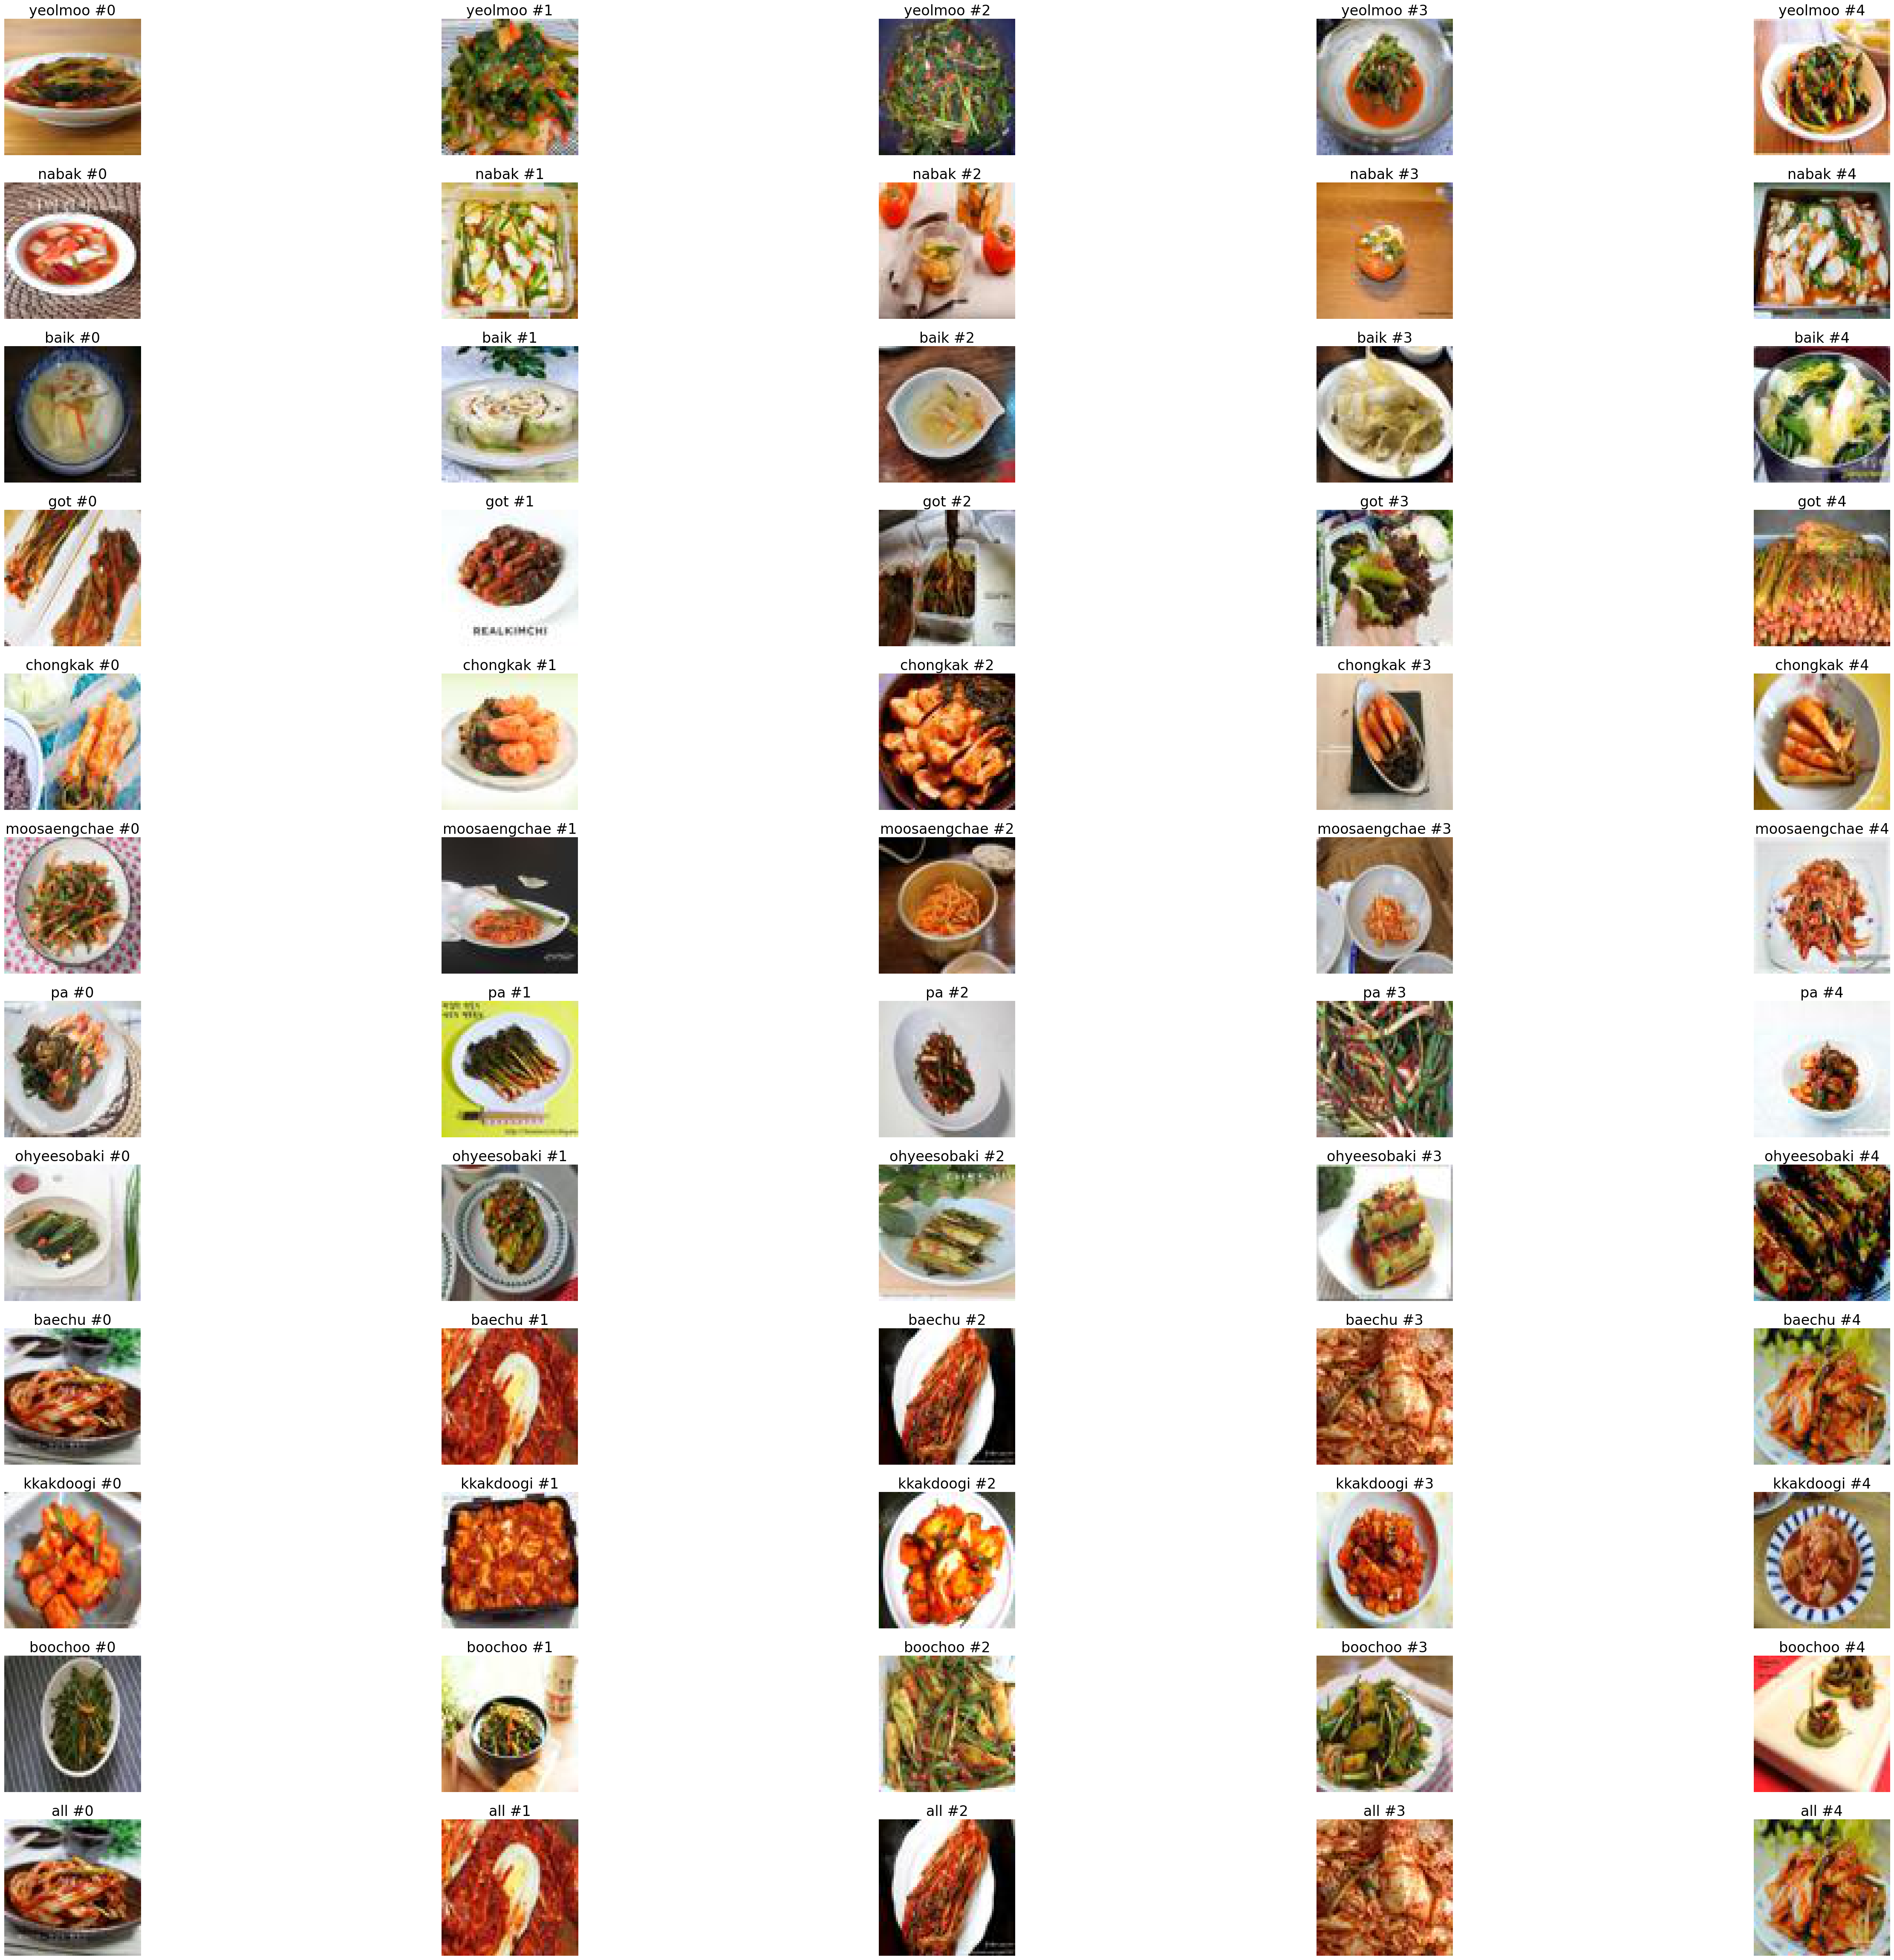

/content/gdrive/MyDrive/dataset_kimchi/dataset


In [ ]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
dataset_path = os.path.join(DATASET_ROOT_PATH, 'dataset')
assert DATASET_ROOT_PATH in dataset_path, print(dataset_path)
train_path = os.path.join(dataset_path, 'train')
ks = os.listdir(train_path)
plt.rc('font', size=20)
fig = plt.figure(figsize=(64,64))
fig.tight_layout()
rows = len(ks); cols = 5
idx=1
for r, k in enumerate(ks):
  if k[0]=='.' : continue
  temp_path = os.path.join(train_path, k)
  l=os.listdir(temp_path)[:5]
  for n in range(0, 5):
    ax = fig.add_subplot(rows, cols, idx)
    ax.imshow(Image.open(os.path.join(temp_path, l[n])))
    ax.set_title(f'{ks[r]} #{n}')
    idx+=1
    ax.axis("off")

plt.show()
print(dataset_path)

## DataLoader 구축

### DataSet Class

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torch.nn as nn
import torchvision.transforms as T
import numpy as np
import os
import pickle
class Dataset_kimchi(Dataset):
    '''
    수정금지
    '''
    def __init__(self,
                root_path,
                to_tensor,
                is_train,
                transform=None,) -> None:

        self.is_train = is_train # 'train', 'val', 'test'

        # label upload #
        self.label_path = os.path.join(root_path, f'{self.is_train}label.pkl')
        with open(self.label_path, 'rb') as f:
            self.labels = pickle.load(f)
            print('trainlabel dictionary loaded successfully from trainlabel.pkl')

        # image upload #
        self.img_path = os.path.join(root_path, self.is_train, 'all')
        self.images = self.upload_images()

        # augmentation #
        self.transform = self.set_augmentation_func(transform)

        # misc #
        self.to_tensor = to_tensor

    def __getitem__(self, idx):
        img_name = self.images[idx].split('/')[-1] # Img_033_0000.jpg
        label=self.labels[img_name] # size [12] (one_hot)
        img_raw = read_image(os.path.join(self.images[idx])) # size [c, h, w]
        img_tensor = img_raw.clone().detach()
        img_after_aug = self.transform(img_tensor) if self.transform is not None else img_tensor.clone()
        size = img_after_aug.size()

        if self.to_tensor :
            img_after_aug = img_after_aug.clone().detach().type(torch.FloatTensor)
            label = torch.tensor(label).clone().detach().type(torch.FloatTensor)
        return {'img':img_after_aug, 'label':label, 'img_name':img_name, 'size':size}

    def __len__(self):
        return len(self.images)

    def set_augmentation_func(self, transform):
        '''
        transform = {
            "ColorJitter" : {brightness:(min, max)), contrast:(min, max)), saturation:(min, max)), hue:(min, max))},
            "RandomRotation" : {degrees:(-degrees, +degrees), interpolation:InterpolationMode.NEAREST},
            "RandomCrop" : {size:(sequence or int)},
            "RandomFlip" : {"RandomHorizontalFlip" : 0.5 , "RandomVerticalFlip" : 0.5}
        }
        '''
        aug_ = nn.Sequential()
        print('\nTransform lists')
        print(*transform.items(), sep="\n")
        if transform == None:
            return None
        for aug_name, val in transform.items():
            if val is None :
                continue
            func = getattr(T, aug_name)(**transform[aug_name])
            aug_.append(func)
        return aug_

    def upload_images(self):
        print(f'Upload Image from {self.img_path}')
        path_ = self.img_path
        pack=[]
        list_ = os.listdir(path_)
        for t in list_:
            pack.append(os.path.join(path_, t))
        return pack



### Augmentation

데이터셋의 원본 김치 사진을 Augmentation 합니다.

기존의 Augmentation 값을 바꾸면서 실험해보거나 필요시 참고 자료에서 새로운 Augmentation을 선언하여 사용할 수 있습니다.

참고 자료 : https://pytorch.org/vision/main/transforms.html

In [ ]:
from torchvision.transforms.functional import InterpolationMode

'''
Data Augmentation Parameters
학습에 민감한 부분이므로 수정하여 성능 변화 관찰
'''
REAL_SIZE=(64, 64) # 실제 이미지 사이즈 (수정금지)
#:::::::::::::::::::::::::::::::::::::::::::::::#
# Color
BRIGHTNESS=(1.0, 1.0) # 밝기 (min, max)
CONTRAST=(.8, 1.2) # 대비 (min, max)
SATURATION=(1.0, 1.0) # 채도 (min, max)
HUE=(-.15, .15) # 색조 (min, max)

# Crop
RANDOMCROP_SIZE=(32,32) # 이미지 랜덤 크롭 사이즈 (h, w)
RANDOMCROP_RATIO=(0.5, 1.0) # 이미지 크롭 랜덤 비율 (min, max)

# Resize
MODEL_INPUT_SIZE = (128, 128) # Model에 적합하도록 이미지를 Resize
PADDING_SIZE=((REAL_SIZE[0]-RANDOMCROP_SIZE[0])//2, (REAL_SIZE[0]-RANDOMCROP_SIZE[0])//2, (REAL_SIZE[0]-RANDOMCROP_SIZE[0])//2, (REAL_SIZE[0]-RANDOMCROP_SIZE[0])//2) # 이미지 패딩 사이즈
DEGREES=(-45,45) # 회전 각도 (min, max)
INTERPOLATION=InterpolationMode.BILINEAR # Interpolation 모드 (웬만해서 변경금지)

# Flip
H_FLIP_PROB=0.2 # 이미지 랜덤 세로축 반전 확률
V_FLIP_PROB=0.2 # 이미지 랜덤 가로축 반전 확률
#:::::::::::::::::::::::::::::::::::::::::::::::#

설정한 Augmentation transform에 적용하기 (Resize는 가장 마지막에 해주세요)

In [ ]:
# (예시)
transform_train = {
    "ColorJitter" : {'brightness':BRIGHTNESS, 'contrast':CONTRAST, 'saturation':SATURATION, 'hue':HUE},
    "RandomRotation" : {'degrees':DEGREES, 'interpolation': INTERPOLATION},
    "RandomCrop" : {'size':RANDOMCROP_SIZE},
    "Pad": {'padding': PADDING_SIZE},
    "RandomResizedCrop" : {'size':REAL_SIZE, 'scale':RANDOMCROP_RATIO},
    "RandomHorizontalFlip" : {'p':H_FLIP_PROB} ,
    "RandomVerticalFlip" : {'p':V_FLIP_PROB},
    "Resize": {'size':MODEL_INPUT_SIZE, 'interpolation':INTERPOLATION}, # 가장 마지막에 설정
}

transform_test = {"Resize": {'size':MODEL_INPUT_SIZE, 'interpolation':INTERPOLATION},}


### Dataset, DataLoader 구축 확인

Dataset 선언

In [ ]:
print(dataset_path)
train_dataset = Dataset_kimchi(
                 root_path=dataset_path,
                 to_tensor=True,
                 is_train="train",
                 transform=transform_train) # init

test_dataset = Dataset_kimchi(
                 root_path=dataset_path,
                 to_tensor=True,
                 is_train="test",
                 transform=transform_test) # init

/content/gdrive/MyDrive/dataset_kimchi/dataset
trainlabel dictionary loaded successfully from trainlabel.pkl
Upload Image from /content/gdrive/MyDrive/dataset_kimchi/dataset/train/all

Transform lists
('ColorJitter', {'brightness': (1.0, 1.0), 'contrast': (0.8, 1.2), 'saturation': (1.0, 1.0), 'hue': (-0.15, 0.15)})
('RandomRotation', {'degrees': (-45, 45), 'interpolation': <InterpolationMode.BILINEAR: 'bilinear'>})
('RandomCrop', {'size': (32, 32)})
('Pad', {'padding': (16, 16, 16, 16)})
('RandomResizedCrop', {'size': (64, 64), 'scale': (0.5, 1.0)})
('RandomHorizontalFlip', {'p': 0.2})
('RandomVerticalFlip', {'p': 0.2})
('Resize', {'size': (128, 128), 'interpolation': <InterpolationMode.BILINEAR: 'bilinear'>})
trainlabel dictionary loaded successfully from trainlabel.pkl
Upload Image from /content/gdrive/MyDrive/dataset_kimchi/dataset/test/all

Transform lists
('Resize', {'size': (128, 128), 'interpolation': <InterpolationMode.BILINEAR: 'bilinear'>})


배치사이즈 및 DataLoader 선언

In [ ]:
BATCH=128

In [ ]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

Augmentation된 Data 확인

TestSet

torch.Size([3, 128, 128])
baechu
Augmentation된 이미지


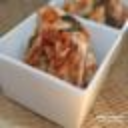


원본이미지


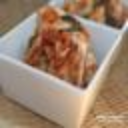

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
idx = 1
EXAMPLE = test_dataset[idx]
REALROOT = test_dataset.images[idx]

img = EXAMPLE['img'] # Tensor형태의 이미지. [C, H, W]
img = img.detach().cpu().numpy() # tensor -> numpy
img = np.transpose(img, (1, 2, 0)) # [C,H,W] -> [H,W,C]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # RGB 채널
img = img.astype(np.uint8).copy() # np.float32 -> np.uint8
img = cv2.resize(img, dsize=MODEL_INPUT_SIZE) # visualization을 위한 사이즈 변경

print(EXAMPLE['img'].shape)
print(kimchi_dict[int(torch.nonzero(EXAMPLE['label'])[0])])
print(f'Augmentation된 이미지')
cv2_imshow(img)
real_img = cv2.imread(REALROOT)
print(f'\n원본이미지')
real_img = cv2.resize(real_img, dsize=MODEL_INPUT_SIZE) # visualization을 위한 사이즈 변경
cv2_imshow(real_img)


TrainSet

torch.Size([3, 128, 128])
baechu
Augmentation된 이미지


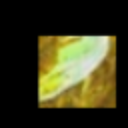


원본이미지


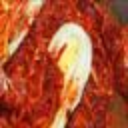

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
idx = 1
EXAMPLE = train_dataset[idx]
REALROOT = train_dataset.images[idx]

img = EXAMPLE['img'] # Tensor형태의 이미지. [C, H, W]
img = img.detach().cpu().numpy() # tensor -> numpy
img = np.transpose(img, (1, 2, 0)) # [C,H,W] -> [H,W,C]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # RGB 채널
img = img.astype(np.uint8).copy() # np.float32 -> np.uint8
img = cv2.resize(img, dsize=MODEL_INPUT_SIZE) # visualization을 위한 사이즈 변경

print(EXAMPLE['img'].shape)
print(kimchi_dict[int(torch.nonzero(EXAMPLE['label'])[0])])
print(f'Augmentation된 이미지')
cv2_imshow(img)
real_img = cv2.imread(REALROOT)
print(f'\n원본이미지')
real_img = cv2.resize(real_img, dsize=MODEL_INPUT_SIZE) # visualization을 위한 사이즈 변경
cv2_imshow(real_img)

## 학습 준비를 위한 모델, Optimizer 초기화

### 모델 선언

### Model Parameters를 수정해서 자신만의 ViT를 만들어보고 성능을 향상시켜보세요

  아래부분만 바꾸시면 되겠습니다!

  Cifar 10에서 학습한 모델을 참고 하셔도 좋습니다.

In [ ]:
NUM_CLASSES = 11
#################### MODEL PARAMETERS (수정가능)
PATCH_SIZE = (16,16)
DIM = 64
DEPTH = 4
NUM_HEADS = 4
MLP_DIM = 64
DROPOUT = 0.3
EMB_DROPOUT = 0.3
####################

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

model = ViT(
    image_size = MODEL_INPUT_SIZE,
    patch_size = PATCH_SIZE,
    num_classes = NUM_CLASSES,
    dim = DIM,
    depth = DEPTH,
    heads = NUM_HEADS,
    mlp_dim = MLP_DIM,
    dropout = DROPOUT,
    emb_dropout = EMB_DROPOUT
)

model = model.to(device)
print(next(model.parameters()).device)
print(model)

cuda
cuda:0
ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=16, p2=16)
    (1): Linear(in_features=768, out_features=64, bias=True)
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (attend): Softmax(dim=-1)
            (to_qkv): Linear(in_features=64, out_features=768, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=256, out_features=64, bias=True)
              (1): Dropout(p=0.3, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=64, out_features=64, bias=True)
              (1): GELU(approximate='no

### Optimizer

In [ ]:
LR = 1.5e-4
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

# 그 밖의 Optimizer 설정 가능 (예시)
# optimizer = torch.optim.SGD(model.parameters(), lr=LR)
# optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# optimizer = torch.optim.RAdam(model.parameters(), lr=LR)

에폭 설정

In [ ]:
EPOCHS = 50

## 학습 코드

EXPERIMENT_NAME : 실험 이름을 설정해서 실험을 체계적으로 관리하세요

In [ ]:
from tqdm import tqdm
import os
from sklearn.metrics import accuracy_score
import torch.nn as nn

# 실험이름 설정
EXPERIMENT_NAME="train1"
os.makedirs(f'{dataset_path}/checkpoint_kimchi/{EXPERIMENT_NAME}',exist_ok=True)

DATASET_SIZE = len(train_dataloader.dataset)
ITER_PER_EPOCH = DATASET_SIZE // BATCH
TOTAL_ITER = ITER_PER_EPOCH * EPOCHS

print(f"""
::::::::::::::::::::::
DATASET_SIZE : {DATASET_SIZE}
BATCH_SIZE : {BATCH}
INIT_LR : {LR}
TOTAL_EPOCHS : {EPOCHS}
ITER_PER_EPOCH : {ITER_PER_EPOCH}
TOTAL_ITER : {TOTAL_ITER}
OPT : {optimizer.__class__}
MODEL_INPUT_SIZE : {MODEL_INPUT_SIZE}
PATCH_SIZE : {PATCH_SIZE}
NUM_CLASSES : {NUM_CLASSES}
PATCH_DIM : {DIM}
MLP_DIM : {MLP_DIM}
DEPTH : {DEPTH}
NUM_HEADS : {NUM_HEADS}
::::::::::::::::::::::
""")

# Model Output 정규화 함수

best_acc = -1
for epoch in range(1,EPOCHS+1):
    model.train()
    total_loss = 0
    correct_prediction = 0
    acc_list = []
    print(f"Training {epoch}/{EPOCHS} Epoch")
    for idx, pack in enumerate(tqdm(train_dataloader)):
        X = pack['img'].to(device)
        Y = pack['label'].to(device)
        outputs, attn = model(X)
        loss = criterion(outputs, Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss / BATCH

        # Train Acc Check
        outputs_ = torch.argmax(outputs, 1)
        outputs_ = outputs_.clone().detach().cpu().numpy()

        Y = torch.nonzero(Y, as_tuple=True)[1]
        Y_ = Y.clone().detach().cpu().numpy()

        # correct_prediction += (torch.argmax(outputs, 1) == Y).sum()
        acc = accuracy_score(Y_, outputs_)
        acc_list.append(acc)
    acc = np.mean(acc_list)

    correct_prediction = correct_prediction/DATASET_SIZE
    print(f'[Epoch: {epoch}] training loss = {total_loss:.3}, training accuracy: {acc*100:.3}%')

    # Model Evaluation
    best_acc_test = -1
    model.eval()
    with torch.no_grad():
      acc_list_test = []
      for idx, pack in enumerate(test_dataloader):
          X = pack['img'].to(device)
          Y = pack['label'].to(device)
          outputs, attn = model(X)
          outputs_ = torch.argmax(outputs, 1)
          outputs_ = outputs_.clone().detach().cpu().numpy()
          labels = Y

          Y = torch.nonzero(Y, as_tuple=True)[1]
          Y_ = Y.clone().detach().cpu().numpy()
          acc_test = accuracy_score(Y_, outputs_)
          acc_list_test.append(acc_test)

      acc_test = np.mean(acc_list_test)

      # Best TestSet Accuracy 일 때 체크포인트를 저장합니다.
      if best_acc_test < acc_test*100:
          best_acc_test = acc_test*100
          torch.save(model.state_dict(),
                      os.path.join(f'{dataset_path}/checkpoint_kimchi/{EXPERIMENT_NAME}',
                                  'model_best.pt'))
          print("best model saved")
      print(f'test set accuracy: {acc_test*100:.3}%\n')
print('Train Finished')


::::::::::::::::::::::
DATASET_SIZE : 8800
BATCH_SIZE : 128
INIT_LR : 0.00015
TOTAL_EPOCHS : 50
ITER_PER_EPOCH : 68
TOTAL_ITER : 3400
OPT : <class 'torch.optim.adamw.AdamW'>
MODEL_INPUT_SIZE : (128, 128)
PATCH_SIZE : (16, 16)
NUM_CLASSES : 11
PATCH_DIM : 64
MLP_DIM : 64
DEPTH : 4
NUM_HEADS : 4
::::::::::::::::::::::

Training 1/50 Epoch


100%|██████████| 69/69 [00:51<00:00,  1.34it/s]


[Epoch: 1] training loss = 1.3, training accuracy: 10.6%
best model saved
test set accuracy: 13.5%

Training 2/50 Epoch


100%|██████████| 69/69 [00:43<00:00,  1.60it/s]


[Epoch: 2] training loss = 1.26, training accuracy: 13.6%
best model saved
test set accuracy: 19.0%

Training 3/50 Epoch


100%|██████████| 69/69 [00:43<00:00,  1.58it/s]


[Epoch: 3] training loss = 1.24, training accuracy: 15.0%
best model saved
test set accuracy: 17.4%

Training 4/50 Epoch


100%|██████████| 69/69 [00:42<00:00,  1.64it/s]


[Epoch: 4] training loss = 1.23, training accuracy: 16.1%
best model saved
test set accuracy: 19.4%

Training 5/50 Epoch


100%|██████████| 69/69 [00:43<00:00,  1.59it/s]


[Epoch: 5] training loss = 1.23, training accuracy: 15.4%
best model saved
test set accuracy: 17.1%

Training 6/50 Epoch


100%|██████████| 69/69 [00:43<00:00,  1.60it/s]


[Epoch: 6] training loss = 1.23, training accuracy: 16.1%
best model saved
test set accuracy: 17.1%

Training 7/50 Epoch


100%|██████████| 69/69 [00:43<00:00,  1.60it/s]


[Epoch: 7] training loss = 1.22, training accuracy: 16.6%
best model saved
test set accuracy: 16.7%

Training 8/50 Epoch


100%|██████████| 69/69 [00:42<00:00,  1.64it/s]


[Epoch: 8] training loss = 1.21, training accuracy: 18.3%
best model saved
test set accuracy: 19.2%

Training 9/50 Epoch


100%|██████████| 69/69 [00:42<00:00,  1.62it/s]


[Epoch: 9] training loss = 1.19, training accuracy: 18.5%
best model saved
test set accuracy: 19.2%

Training 10/50 Epoch


100%|██████████| 69/69 [00:42<00:00,  1.62it/s]


[Epoch: 10] training loss = 1.17, training accuracy: 20.0%
best model saved
test set accuracy: 20.9%

Training 11/50 Epoch


100%|██████████| 69/69 [00:43<00:00,  1.57it/s]


[Epoch: 11] training loss = 1.16, training accuracy: 21.1%
best model saved
test set accuracy: 23.9%

Training 12/50 Epoch


100%|██████████| 69/69 [00:43<00:00,  1.58it/s]


[Epoch: 12] training loss = 1.15, training accuracy: 21.1%
best model saved
test set accuracy: 26.4%

Training 13/50 Epoch


100%|██████████| 69/69 [00:42<00:00,  1.61it/s]


[Epoch: 13] training loss = 1.15, training accuracy: 21.1%
best model saved
test set accuracy: 22.5%

Training 14/50 Epoch


100%|██████████| 69/69 [00:42<00:00,  1.63it/s]


[Epoch: 14] training loss = 1.13, training accuracy: 22.5%
best model saved
test set accuracy: 25.0%

Training 15/50 Epoch


100%|██████████| 69/69 [00:42<00:00,  1.63it/s]


[Epoch: 15] training loss = 1.14, training accuracy: 21.8%
best model saved
test set accuracy: 24.2%

Training 16/50 Epoch


100%|██████████| 69/69 [00:42<00:00,  1.61it/s]


[Epoch: 16] training loss = 1.12, training accuracy: 22.9%
best model saved
test set accuracy: 26.0%

Training 17/50 Epoch


100%|██████████| 69/69 [00:42<00:00,  1.64it/s]


[Epoch: 17] training loss = 1.12, training accuracy: 23.3%
best model saved
test set accuracy: 28.0%

Training 18/50 Epoch


100%|██████████| 69/69 [00:43<00:00,  1.59it/s]


[Epoch: 18] training loss = 1.11, training accuracy: 24.3%
best model saved
test set accuracy: 26.8%

Training 19/50 Epoch


100%|██████████| 69/69 [00:43<00:00,  1.58it/s]


[Epoch: 19] training loss = 1.11, training accuracy: 23.3%
best model saved
test set accuracy: 27.0%

Training 20/50 Epoch


100%|██████████| 69/69 [00:42<00:00,  1.63it/s]


[Epoch: 20] training loss = 1.11, training accuracy: 23.4%
best model saved
test set accuracy: 26.2%

Training 21/50 Epoch


100%|██████████| 69/69 [00:42<00:00,  1.61it/s]


[Epoch: 21] training loss = 1.11, training accuracy: 23.5%
best model saved
test set accuracy: 26.5%

Training 22/50 Epoch


100%|██████████| 69/69 [00:42<00:00,  1.63it/s]


[Epoch: 22] training loss = 1.09, training accuracy: 25.0%
best model saved
test set accuracy: 25.8%

Training 23/50 Epoch


100%|██████████| 69/69 [00:42<00:00,  1.62it/s]


[Epoch: 23] training loss = 1.1, training accuracy: 24.5%
best model saved
test set accuracy: 28.9%

Training 24/50 Epoch


100%|██████████| 69/69 [00:42<00:00,  1.62it/s]


[Epoch: 24] training loss = 1.09, training accuracy: 24.7%
best model saved
test set accuracy: 28.6%

Training 25/50 Epoch


100%|██████████| 69/69 [00:41<00:00,  1.65it/s]


[Epoch: 25] training loss = 1.08, training accuracy: 25.6%
best model saved
test set accuracy: 28.8%

Training 26/50 Epoch


100%|██████████| 69/69 [00:42<00:00,  1.62it/s]


[Epoch: 26] training loss = 1.08, training accuracy: 25.9%
best model saved
test set accuracy: 26.8%

Training 27/50 Epoch


100%|██████████| 69/69 [00:42<00:00,  1.62it/s]


[Epoch: 27] training loss = 1.08, training accuracy: 26.6%
best model saved
test set accuracy: 29.4%

Training 28/50 Epoch


100%|██████████| 69/69 [00:41<00:00,  1.66it/s]


[Epoch: 28] training loss = 1.08, training accuracy: 25.3%
best model saved
test set accuracy: 30.3%

Training 29/50 Epoch


100%|██████████| 69/69 [00:42<00:00,  1.63it/s]


[Epoch: 29] training loss = 1.08, training accuracy: 26.0%
best model saved
test set accuracy: 29.3%

Training 30/50 Epoch


100%|██████████| 69/69 [00:42<00:00,  1.61it/s]


[Epoch: 30] training loss = 1.07, training accuracy: 26.4%
best model saved
test set accuracy: 31.2%

Training 31/50 Epoch


100%|██████████| 69/69 [00:42<00:00,  1.64it/s]


[Epoch: 31] training loss = 1.08, training accuracy: 26.3%
best model saved
test set accuracy: 29.8%

Training 32/50 Epoch


100%|██████████| 69/69 [00:41<00:00,  1.66it/s]


[Epoch: 32] training loss = 1.07, training accuracy: 26.8%
best model saved
test set accuracy: 30.4%

Training 33/50 Epoch


100%|██████████| 69/69 [00:42<00:00,  1.61it/s]


[Epoch: 33] training loss = 1.07, training accuracy: 26.9%
best model saved
test set accuracy: 30.0%

Training 34/50 Epoch


100%|██████████| 69/69 [00:41<00:00,  1.65it/s]


[Epoch: 34] training loss = 1.07, training accuracy: 26.5%
best model saved
test set accuracy: 31.4%

Training 35/50 Epoch


100%|██████████| 69/69 [00:41<00:00,  1.64it/s]


[Epoch: 35] training loss = 1.07, training accuracy: 26.9%
best model saved
test set accuracy: 30.5%

Training 36/50 Epoch


100%|██████████| 69/69 [00:41<00:00,  1.65it/s]


[Epoch: 36] training loss = 1.06, training accuracy: 27.3%
best model saved
test set accuracy: 30.1%

Training 37/50 Epoch


100%|██████████| 69/69 [00:42<00:00,  1.61it/s]


[Epoch: 37] training loss = 1.06, training accuracy: 28.1%
best model saved
test set accuracy: 31.8%

Training 38/50 Epoch


100%|██████████| 69/69 [00:41<00:00,  1.66it/s]


[Epoch: 38] training loss = 1.06, training accuracy: 27.5%
best model saved
test set accuracy: 32.3%

Training 39/50 Epoch


100%|██████████| 69/69 [00:41<00:00,  1.65it/s]


[Epoch: 39] training loss = 1.06, training accuracy: 27.8%
best model saved
test set accuracy: 29.2%

Training 40/50 Epoch


100%|██████████| 69/69 [00:42<00:00,  1.63it/s]


[Epoch: 40] training loss = 1.06, training accuracy: 27.5%
best model saved
test set accuracy: 31.6%

Training 41/50 Epoch


100%|██████████| 69/69 [00:42<00:00,  1.64it/s]


[Epoch: 41] training loss = 1.05, training accuracy: 28.1%
best model saved
test set accuracy: 32.8%

Training 42/50 Epoch


100%|██████████| 69/69 [00:41<00:00,  1.66it/s]


[Epoch: 42] training loss = 1.05, training accuracy: 27.1%
best model saved
test set accuracy: 32.7%

Training 43/50 Epoch


100%|██████████| 69/69 [00:41<00:00,  1.65it/s]


[Epoch: 43] training loss = 1.04, training accuracy: 28.5%
best model saved
test set accuracy: 31.2%

Training 44/50 Epoch


100%|██████████| 69/69 [00:42<00:00,  1.61it/s]


[Epoch: 44] training loss = 1.05, training accuracy: 28.4%
best model saved
test set accuracy: 31.5%

Training 45/50 Epoch


100%|██████████| 69/69 [00:42<00:00,  1.64it/s]


[Epoch: 45] training loss = 1.05, training accuracy: 28.7%
best model saved
test set accuracy: 30.9%

Training 46/50 Epoch


100%|██████████| 69/69 [00:42<00:00,  1.63it/s]


[Epoch: 46] training loss = 1.04, training accuracy: 29.5%
best model saved
test set accuracy: 31.0%

Training 47/50 Epoch


100%|██████████| 69/69 [00:43<00:00,  1.59it/s]


[Epoch: 47] training loss = 1.04, training accuracy: 28.7%
best model saved
test set accuracy: 30.2%

Training 48/50 Epoch


100%|██████████| 69/69 [00:42<00:00,  1.63it/s]


[Epoch: 48] training loss = 1.04, training accuracy: 28.9%
best model saved
test set accuracy: 32.2%

Training 49/50 Epoch


100%|██████████| 69/69 [00:41<00:00,  1.65it/s]


[Epoch: 49] training loss = 1.04, training accuracy: 28.0%
best model saved
test set accuracy: 30.2%

Training 50/50 Epoch


100%|██████████| 69/69 [00:42<00:00,  1.63it/s]


[Epoch: 50] training loss = 1.04, training accuracy: 29.2%
best model saved
test set accuracy: 31.1%

Train Finished


## 학습된 모델 성능 평가 (Test Dataset)

### 테스트 DataSet 구축



In [ ]:
transform_test = {"Resize": {'size':MODEL_INPUT_SIZE, 'interpolation':INTERPOLATION},}

test_dataset = Dataset_kimchi(
                 root_path=dataset_path,
                 to_tensor=True,
                 is_train="test",
                 transform=transform_test) # init

trainlabel dictionary loaded successfully from trainlabel.pkl
Upload Image from /content/gdrive/MyDrive/dataset_kimchi/dataset/test/all

Transform lists
('Resize', {'size': (128, 128), 'interpolation': <InterpolationMode.BILINEAR: 'bilinear'>})


Test시에는 Batch Size를 1로 설정합니다.

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size = 1, shuffle=False)

모델 체크포인트 불러오기 (Best Model)

In [ ]:
CHECKPOINT_PATH = os.path.join(f'{dataset_path}/checkpoint_kimchi/{EXPERIMENT_NAME}',
                                    'model_best.pt')
model.load_state_dict(torch.load(CHECKPOINT_PATH))
model = model.to(device)

### 성능 평가

성능 평가를 위한 코드

100%|██████████| 2200/2200 [00:22<00:00, 98.12it/s] 


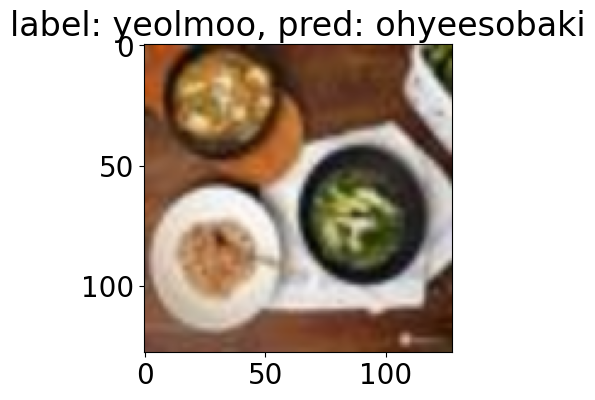

Accuracy of the network on the test images: 31.1 %


In [ ]:
img_num = 10

model.eval()
fig = plt.figure(figsize=(30,4))

kimchi_list = ['baechu', 'baik', 'boochoo', 'chongkak', 'got', 'kkakdoogi', 'moosaengchae', 'nabak', 'ohyeesobaki', 'pa', 'yeolmoo']
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다

with torch.no_grad():
    acc_list = []
    for idx, pack in enumerate(tqdm(test_dataloader)):
        X = pack['img'].to(device)
        Y = pack['label'].to(device)
        labels = Y
        img = X.cpu().detach()
        img = img.permute(0,2,3,1).numpy().astype(np.int64)

        outputs, attn = model(X)
        outputs_ = torch.argmax(outputs, 1)
        outputs_ = outputs_.clone().detach().cpu().numpy()
        Y = torch.nonzero(Y, as_tuple=True)[1]
        Y_ = Y.clone().detach().cpu().numpy()

        acc = accuracy_score(Y_, outputs_)
        acc_list.append(acc)

    plt.imshow(img[0])
    plt.title('label: '+kimchi_list[torch.argmax(labels[0])] + f', pred: {kimchi_list[outputs_[0]]}')
    plt.show()

    acc = np.mean(acc_list)
    print(f'Accuracy of the network on the test images: {acc*100:.3} %')

## [Bonus] 실제 사진으로 성능 평가


실제 김치 사진을 촬영해서 Colab 환경에 업로드 해보세요 (휴대폰으로 촬영 한 다음 개인 컴퓨터에 업로드 되어 있어야 합니다.)

In [ ]:
from google.colab import files
uploaded = files.upload()

img_name = list(uploaded.keys())[0]

In [ ]:
from PIL import Image

image = Image.open(f'{img_name}').convert("RGB")

transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.Resize(size=MODEL_INPUT_SIZE, interpolation=InterpolationMode.BILINEAR)
])
img_tensor = transform(image)
img_tensor = img_tensor.unsqueeze(0).to(device)
img_tensor = img_tensor.type(torch.float32)

In [ ]:
softmax = nn.Softmax()
probabilities, attn = model(img_tensor)
probabilities = softmax(probabilities)
probabilities = torch.squeeze(probabilities)
kimchi_list = ['baechu', 'baik', 'boochoo', 'chongkak', 'got', 'kkakdoogi', 'moosaengchae', 'nabak', 'ohyeesobaki', 'pa', 'yeolmoo']
output_data = dict()
for i in range(0, 11):
  score = round(probabilities[i].item(),3) * 100
  print(kimchi_list[i] + " : " + f'{score:.2f}%')
  output_data[kimchi_list[i]] = round(probabilities[i].item(),3) * 100

### Output Visualization

In [ ]:
import matplotlib.pyplot as plt
x = list(output_data.keys())
y = list(output_data.values())

plt.barh(range(len(output_data)), y, tick_label = x)
plt.show()

In [ ]:
fig = plt.figure(figsize=(30,4))

y = np.array(y)
max_idx = np.argmax(y)
label = kimchi_list[max_idx]
pred = y[max_idx]


tf = transforms.ToTensor()
image_t = tf(image)
print(image_t.size())

image_t = image_t.permute(1, 2, 0)
print(image_t.size())


plt.imshow(image_t)
plt.title('pred: ' + str(label) + ' , prob: ' + f'{pred:.2f}')